In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="1wZz1zRH0f4dghdwk80E")
project = rf.workspace("yolotest1").project("yolov5test2")
version = project.version(1)
dataset = version.download("yolov5")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to yolov5test2-1 in yolov5pytorch:: 100%|██████████| 1802/1802 [00:00<00:00, 4567.07it/s]


In [3]:
!git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 17088, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 17088 (delta 23), reused 7 (delta 7), pack-reused 17051 (from 3)
Receiving objects: 100% (17088/17088), 15.70 MiB | 16.44 MiB/s, done.
Resolving deltas: 100% (11728/11728), done.


In [4]:
%cd yolov5
!pip install -r requirements.txt

/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 905.3/905.3 kB 23.3 MB/s eta 0:00:00


In [7]:
!python3 train.py --img 640 --batch 16 --epochs 100 --data /content/yolov5test2-1/data.yaml --weights yolov5s.pt --name baseball_detection3

Streaming output truncated to the last 5000 lines.
  with torch.cuda.amp.autocast(amp):
      51/99       4.4G    0.02645    0.01247   0.001951         35        640:  61% 30/49 [00:13<00:07,  2.40it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      51/99       4.4G     0.0264     0.0124   0.001906         35        640:  63% 31/49 [00:14<00:07,  2.54it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      51/99       4.4G    0.02638    0.01241   0.001874         43        640:  65% 32/49 [00:14<00:05,  2.86it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):


In [33]:
from google.colab import files
files.download('/content/yolov5/runs/train/baseball_detection32')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
!pip install piexif

from PIL import Image
import piexif
from pathlib import Path

In [37]:
def preprocess_image(image_path, output_path=None):
    """
    Preprocess an image to match the training dataset preprocessing:
    1. Auto-orient using EXIF data and strip EXIF
    2. Resize to 640x640 with stretching

    Args:
        image_path (str): Path to input image
        output_path (str, optional): Path to save processed image. If None, overwrites original.

    Returns:
        PIL.Image: Processed image object
    """
    # Open the image
    img = Image.open(image_path)

    # Auto-orient based on EXIF data
    try:
        # Check if image has EXIF data
        exif = img._getexif()
        if exif:
            # Get the orientation tag (274)
            orientation = exif.get(274)
            if orientation is not None:
                # Rotate/flip based on EXIF orientation
                exif_orientation_map = {
                    2: (Image.FLIP_LEFT_RIGHT,),
                    3: (Image.ROTATE_180,),
                    4: (Image.FLIP_TOP_BOTTOM,),
                    5: (Image.ROTATE_270, Image.FLIP_LEFT_RIGHT),
                    6: (Image.ROTATE_270,),
                    7: (Image.ROTATE_90, Image.FLIP_LEFT_RIGHT),
                    8: (Image.ROTATE_90,)
                }
                if orientation in exif_orientation_map:
                    for operation in exif_orientation_map[orientation]:
                        img = img.transpose(operation)
    except:
        # If EXIF processing fails, continue with original image
        pass

    # Strip all EXIF data
    img_without_exif = Image.new(img.mode, img.size)
    img_without_exif.putdata(list(img.getdata()))

    # Resize to 640x640 with stretching
    img_resized = img_without_exif.resize((640, 640), Image.Resampling.LANCZOS)

    # Save if output path provided
    if output_path:
        img_resized.save(output_path)
    else:
        img_resized.save(image_path)

    return img_resized

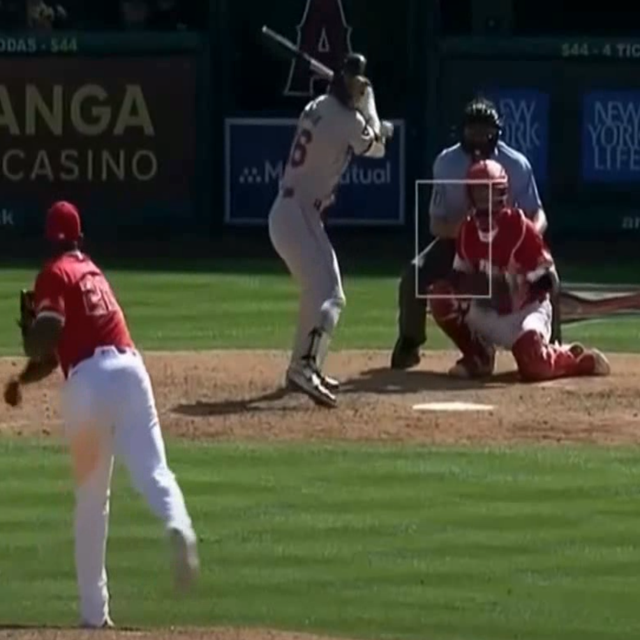

In [38]:
input_path = r'/content/baseball_img.png'
output_path = r'/content/baseball_img.png'
preprocess_image(input_path, output_path)

In [39]:
import torch
import cv2

In [40]:
class BaseballDetector:
    def __init__(self, weights_path, ball_class=0, conf_threshold=0.5):
        """
        Initialize the baseball detector.
        weights_path: Path to YOLOv5 weights (e.g., best.pt).
        ball_class: Class index for the baseball in the YOLO model.
        conf_threshold: Confidence threshold for detection.
        """
        self.model = torch.hub.load('ultralytics/yolov5', 'custom', path=weights_path)
        self.model.conf = conf_threshold
        self.ball_class = ball_class

    def detect_baseball(self, image_path, output_path=None):
        """
        Detect baseball in a still image.
        image_path: Path to the input image.
        output_path: Path to save the output image with detections (optional).
        """
        # Load image
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Image not found: {image_path}")

        # Run YOLO detection
        results = self.model(image)                       # Since the model was trained with images of size 416x416, but if I use that then it messes up!
        detections = results.xyxy[0].cpu().numpy()

        # Filter detections for the baseball class
        baseball_detections = [
            det for det in detections if int(det[5]) == self.ball_class
        ]

        # Draw bounding boxes around detected baseballs
        for det in baseball_detections:
            x1, y1, x2, y2, conf, cls = det
            cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
            cv2.putText(
                image,
                f"Baseball {conf:.2f}",
                (int(x1), int(y1) - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (0, 255, 0),
                2,
            )

        # Save the output image if an output path is provided
        if output_path:
            cv2.imwrite(output_path, image)

        return baseball_detections

In [44]:
detector = BaseballDetector(
        weights_path='/content/yolov5/runs/train/baseball_detection32/weights/best.pt',
        ball_class=1,  # Set the class index for the baseball
        conf_threshold=0.1                                 # For some reason, we're getting detections with 0.12 confidence threshold. (probably cause the images are so different --> FIX THIS)
    )

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-1-4 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [46]:
detections = detector.detect_baseball(
        image_path='/content/baseball_img.png',
        output_path=f'/content/baseball_image_detected_2.png'  # Save annotated image
    )

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
